# High & Low - profitable

### Import Library

In [120]:
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_ta as ta

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [121]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [122]:
data = dataset.copy()
data = data[100*data.index.hour + data.index.minute < 1430]
data["ma_line"] = data["Close"].rolling(20).mean()
data['above_ma'] = data.apply(lambda r: 1 if r['Close'] > r['ma_line'] else 0, axis=1)
# data['below_ma'] = data.apply(lambda r: 1 if r['Close'] < r['ma_line'] else 0, axis=1)
data['tam_150bar'] = data['above_ma'].rolling(150).sum()
data['tam_250bar'] = data['above_ma'].rolling(250).sum()
data = data.drop(columns=['ma_line', 'above_ma'])
data

,Open,High,Low,Close,Volume,tam_150bar,tam_250bar
Date,,,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,1812,NaN,NaN
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,1323,NaN,NaN
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207,NaN,NaN
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196,NaN,NaN
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765,NaN,NaN
...,...,...,...,...,...,...,...
2024-07-16 14:05:00,1303.3,1303.4,1301.7,1302.3,4880,63.0,106.0
2024-07-16 14:10:00,1302.4,1302.5,1300.1,1300.6,8159,63.0,105.0
2024-07-16 14:15:00,1300.5,1302.1,1299.1,1302.0,9624,63.0,104.0


In [123]:
day_data = data.resample("D").agg({
    'High': 'max',
    'Low': 'min'
    }).rename(columns={'High': 'Day_High', 'Low': 'Day_Low'})
day_data.dropna(inplace=True)

In [124]:
data = data.assign(time_d=pd.PeriodIndex(data.index, freq='1D').to_timestamp())
data = pd.merge(data, day_data, left_on="time_d", right_index=True, how="left")
data = data.drop(columns=['Volume', 'time_d'])
data

,Open,High,Low,Close,tam_150bar,tam_250bar,Day_High,Day_Low
Date,,,,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,NaN,NaN,954.6,942.3
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,NaN,NaN,954.6,942.3
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,NaN,NaN,954.6,942.3
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,NaN,NaN,954.6,942.3
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,NaN,NaN,954.6,942.3
...,...,...,...,...,...,...,...,...
2024-07-16 14:05:00,1303.3,1303.4,1301.7,1302.3,63.0,106.0,1308.7,1299.1
2024-07-16 14:10:00,1302.4,1302.5,1300.1,1300.6,63.0,105.0,1308.7,1299.1
2024-07-16 14:15:00,1300.5,1302.1,1299.1,1302.0,63.0,104.0,1308.7,1299.1


In [126]:
data['group'] = 0
for i, row in data.iterrows():
    if 100*row.name.hour + row.name.minute < 1430:
        current_price = row['Close']
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date+' 14:30:00')]
        if data_to_end_day.empty:
            continue
        last_price = data_to_end_day.iloc[-1]['Close']
        long_stoploss = short_stoploss = False
        has_long_profit = has_short_profit = False
        if current_price < last_price:
            has_long_profit = True
        elif current_price > last_price:
            has_short_profit = True
        for k, wrow in data_to_end_day.iterrows():
            if wrow['Low'] < current_price - 3:
                long_stoploss = True
            if wrow['High'] > current_price + 3:
                short_stoploss = True
        #
        if has_long_profit and not long_stoploss:
            # Long
            data.at[i, 'group'] = 1
        if has_short_profit and not short_stoploss:
            # Short
            data.at[i, 'group'] = 2
data

,Open,High,Low,Close,tam_150bar,tam_250bar,Day_High,Day_Low,group
Date,,,,,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,NaN,NaN,954.6,942.3,1
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,NaN,NaN,954.6,942.3,1
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,NaN,NaN,954.6,942.3,1
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,NaN,NaN,954.6,942.3,1
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,NaN,NaN,954.6,942.3,1
...,...,...,...,...,...,...,...,...,...
2024-07-16 14:05:00,1303.3,1303.4,1301.7,1302.3,63.0,106.0,1308.7,1299.1,2
2024-07-16 14:10:00,1302.4,1302.5,1300.1,1300.6,63.0,105.0,1308.7,1299.1,1
2024-07-16 14:15:00,1300.5,1302.1,1299.1,1302.0,63.0,104.0,1308.7,1299.1,2


In [147]:
len(data[data.group == 2])/len(data)

0.3365020330562456

In [129]:
data["RSI"] = ta.rsi(data["Close"], length=14)
macd = ta.macd(data['Close'], 26, 12, 9)
data = data.assign(MACDh=macd['MACDh_12_26_9'])
data['ibs'] = data.apply(
        lambda x: (2 if (x["High"] == x["Low"]) else (x["Close"] - x["Low"]) / (x["High"] - x["Low"])), axis=1)
data['ibs_shift'] = data['ibs'].shift(1)

In [130]:
data

,Open,High,Low,Close,tam_150bar,tam_250bar,Day_High,Day_Low,group,RSI,MACDh,ibs,ibs_shift
Date,,,,,,,,,,,,,
2018-08-13 09:00:00,943.5,943.6,942.9,943.1,NaN,NaN,954.6,942.3,1,NaN,NaN,0.285714,NaN
2018-08-13 09:05:00,943.1,943.5,942.9,943.3,NaN,NaN,954.6,942.3,1,NaN,NaN,0.666667,0.285714
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,NaN,NaN,954.6,942.3,1,NaN,NaN,0.714286,0.666667
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,NaN,NaN,954.6,942.3,1,NaN,NaN,0.375000,0.714286
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,NaN,NaN,954.6,942.3,1,NaN,NaN,1.000000,0.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 14:05:00,1303.3,1303.4,1301.7,1302.3,63.0,106.0,1308.7,1299.1,2,33.020153,-0.588300,0.352941,0.375000
2024-07-16 14:10:00,1302.4,1302.5,1300.1,1300.6,63.0,105.0,1308.7,1299.1,1,27.245276,-0.691793,0.208333,0.352941
2024-07-16 14:15:00,1300.5,1302.1,1299.1,1302.0,63.0,104.0,1308.7,1299.1,2,37.014656,-0.630273,0.966667,0.208333


In [131]:
data.dropna(inplace=True)

In [132]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

In [133]:
 # split dataset in features and target variable
feature_cols = ["RSI", "MACDh", "ibs", "ibs_shift", "tam_150bar", "tam_250bar"]
X = data[feature_cols]  # Features
y = data['group'] # Target variable
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # 80% training and 20% test

In [134]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [100]:
%%time

parameters = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [8],
    'gamma': [0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_test, y_test)]
# Create XGBClassifier model
model_xgb = xgb.XGBClassifier(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model_xgb, parameters)

clf.fit(X_train, y_train)

CPU times: user 5min 47s, sys: 1.34 s, total: 5min 48s
Wall time: 1min 1s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     eval_set=[(                           RSI     MACDh       ibs  ibs_shift  tam_150bar  \
Date                                                                        
2018-08-20 09:20:00  41.983551 -0.197948  0.727273   0.200000        61.0   
2018-08-20 09:25:00  4...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'gamma': [0.01, 0.02], 'learning_rate': [0.01, 0.05],
                         'max_depth': [8], 'n_estimators': [100, 150, 200],
                         'random_state': [42]})

In [101]:
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
Best validation score = 0.5626149676328114


In [135]:
# best_model = xgb.XGBClassifier(**clf.best_params_, objective='reg:squarederror')
# best_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
best_model = xgb.XGBClassifier(n_estimators=200, max_depth=8, learning_rate=0.05, gamma=0.01, random_state=42)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

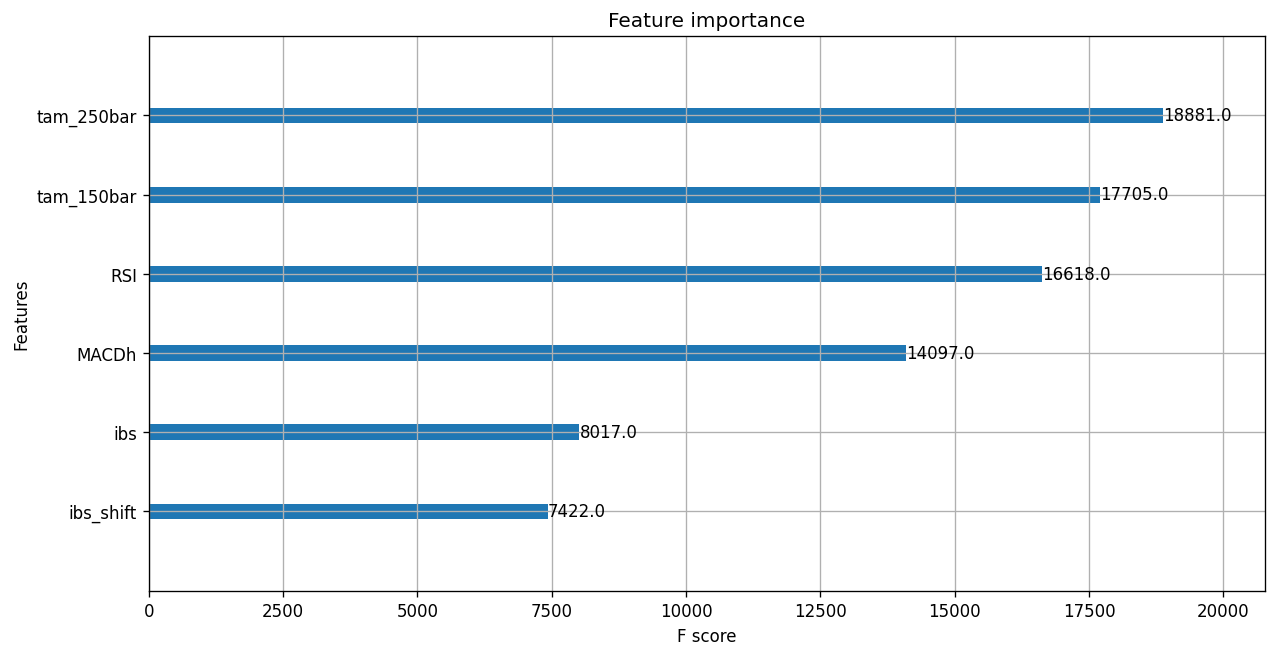

In [136]:
plot_importance(best_model)

In [137]:
y_pred = best_model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [2 2 2 2 2]
y_pred = [1 1 1 1 1]


In [138]:
from sklearn.metrics import mean_squared_error
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 1.2724118789897307


In [139]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("R2_score:", metrics.r2_score(y_test, y_pred))

Accuracy: 0.3670552317513183
R2_score: -0.939995405006121


In [140]:
X_result = X_test.copy()
X_result = X_result.assign(Predicts=y_pred)
X_result = X_result[['Predicts']]
data_result = data.copy()
data_result = pd.merge(data_result, X_result, left_index=True, right_index=True, how="left")
data_result.dropna(inplace=True)
data_result

,Open,High,Low,Close,tam_150bar,tam_250bar,Day_High,Day_Low,group,RSI,MACDh,ibs,ibs_shift,Predicts
Date,,,,,,,,,,,,,,
2023-05-15 13:30:00,1070.7,1071.3,1070.5,1070.9,100.0,169.0,1071.7,1065.7,2,64.522921,-0.278656,0.500000,0.700000,1.0
2023-05-15 13:35:00,1070.9,1071.1,1070.4,1070.6,100.0,169.0,1071.7,1065.7,2,61.745816,-0.248113,0.285714,0.500000,1.0
2023-05-15 13:40:00,1070.7,1070.9,1070.0,1070.0,101.0,169.0,1071.7,1065.7,2,56.507418,-0.265317,0.000000,0.285714,1.0
2023-05-15 13:45:00,1070.1,1070.4,1069.6,1069.7,101.0,168.0,1071.7,1065.7,2,54.038814,-0.291795,0.125000,0.000000,1.0
2023-05-15 13:50:00,1069.7,1071.0,1069.7,1070.6,101.0,168.0,1071.7,1065.7,2,59.723467,-0.245452,0.692308,0.125000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 14:05:00,1303.3,1303.4,1301.7,1302.3,63.0,106.0,1308.7,1299.1,2,33.020153,-0.588300,0.352941,0.375000,2.0
2024-07-16 14:10:00,1302.4,1302.5,1300.1,1300.6,63.0,105.0,1308.7,1299.1,1,27.245276,-0.691793,0.208333,0.352941,2.0
2024-07-16 14:15:00,1300.5,1302.1,1299.1,1302.0,63.0,104.0,1308.7,1299.1,2,37.014656,-0.630273,0.966667,0.208333,0.0


In [141]:
data_result[(data_result.group == 1) & (data_result.Predicts == 2)]

,Open,High,Low,Close,tam_150bar,tam_250bar,Day_High,Day_Low,group,RSI,MACDh,ibs,ibs_shift,Predicts
Date,,,,,,,,,,,,,,
2023-05-16 09:20:00,1066.6,1066.6,1065.7,1065.7,91.0,158.0,1069.3,1064.5,1,35.253842,-0.458683,0.000000,0.909091,2.0
2023-05-16 09:25:00,1065.7,1066.2,1065.3,1066.1,90.0,157.0,1069.3,1064.5,1,38.330414,-0.400106,0.888889,0.000000,2.0
2023-05-16 09:30:00,1065.9,1066.2,1065.4,1065.5,89.0,156.0,1069.3,1064.5,1,35.597952,-0.377142,0.125000,0.888889,2.0
2023-05-16 09:35:00,1065.6,1065.6,1064.5,1065.1,88.0,155.0,1069.3,1064.5,1,33.864740,-0.364081,0.545455,0.125000,2.0
2023-05-16 09:40:00,1065.1,1065.6,1065.1,1065.5,87.0,154.0,1069.3,1064.5,1,37.159696,-0.306027,0.800000,0.545455,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 09:00:00,1301.5,1302.5,1301.5,1301.6,47.0,103.0,1308.7,1299.1,1,55.129325,-0.061470,0.100000,0.852941,2.0
2024-07-16 09:05:00,1301.6,1301.9,1300.7,1300.7,48.0,103.0,1308.7,1299.1,1,52.149036,0.182420,0.000000,0.100000,2.0
2024-07-16 09:10:00,1300.9,1301.0,1300.3,1301.0,49.0,103.0,1308.7,1299.1,1,53.059961,0.357274,1.000000,0.000000,2.0


In [142]:
data_result[(data_result.group == 2) & (data_result.Predicts == 1)]

,Open,High,Low,Close,tam_150bar,tam_250bar,Day_High,Day_Low,group,RSI,MACDh,ibs,ibs_shift,Predicts
Date,,,,,,,,,,,,,,
2023-05-15 13:30:00,1070.7,1071.3,1070.5,1070.9,100.0,169.0,1071.7,1065.7,2,64.522921,-0.278656,0.500000,0.700000,1.0
2023-05-15 13:35:00,1070.9,1071.1,1070.4,1070.6,100.0,169.0,1071.7,1065.7,2,61.745816,-0.248113,0.285714,0.500000,1.0
2023-05-15 13:40:00,1070.7,1070.9,1070.0,1070.0,101.0,169.0,1071.7,1065.7,2,56.507418,-0.265317,0.000000,0.285714,1.0
2023-05-15 13:45:00,1070.1,1070.4,1069.6,1069.7,101.0,168.0,1071.7,1065.7,2,54.038814,-0.291795,0.125000,0.000000,1.0
2023-05-15 13:50:00,1069.7,1071.0,1069.7,1070.6,101.0,168.0,1071.7,1065.7,2,59.723467,-0.245452,0.692308,0.125000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 10:50:00,1307.8,1307.8,1306.7,1307.4,56.0,115.0,1308.7,1299.1,2,66.526938,0.369864,0.636364,0.428571,1.0
2024-07-16 10:55:00,1307.3,1307.7,1306.9,1307.5,56.0,116.0,1308.7,1299.1,2,66.854324,0.295727,0.750000,0.636364,1.0
2024-07-16 11:25:00,1307.1,1307.8,1306.9,1307.7,61.0,119.0,1308.7,1299.1,2,66.029696,-0.083526,0.888889,0.500000,1.0


In [143]:
data_result[data_result.index > '2024-07-16 08:00:00']

,Open,High,Low,Close,tam_150bar,tam_250bar,Day_High,Day_Low,group,RSI,MACDh,ibs,ibs_shift,Predicts
Date,,,,,,,,,,,,,,
2024-07-16 09:00:00,1301.5,1302.5,1301.5,1301.6,47.0,103.0,1308.7,1299.1,1,55.129325,-0.061470,0.100000,0.852941,2.0
2024-07-16 09:05:00,1301.6,1301.9,1300.7,1300.7,48.0,103.0,1308.7,1299.1,1,52.149036,0.182420,0.000000,0.100000,2.0
2024-07-16 09:10:00,1300.9,1301.0,1300.3,1301.0,49.0,103.0,1308.7,1299.1,1,53.059961,0.357274,1.000000,0.000000,2.0
2024-07-16 09:15:00,1301.0,1301.8,1300.9,1301.6,50.0,103.0,1308.7,1299.1,1,54.908797,0.498023,0.777778,1.000000,1.0
2024-07-16 09:20:00,1301.6,1302.2,1301.0,1301.4,51.0,103.0,1308.7,1299.1,1,54.143266,0.557828,0.333333,0.777778,0.0
2024-07-16 09:25:00,1301.3,1302.9,1301.3,1302.7,51.0,103.0,1308.7,1299.1,0,58.220642,0.658218,0.875000,0.333333,0.0
2024-07-16 09:30:00,1302.5,1303.2,1301.4,1301.4,52.0,103.0,1308.7,1299.1,1,53.132892,0.611358,0.000000,0.875000,0.0
2024-07-16 09:35:00,1301.4,1301.9,1301.2,1301.2,53.0,103.0,1308.7,1299.1,1,52.374593,0.543467,0.000000,0.000000,2.0
2024-07-16 09:40:00,1301.2,1302.5,1301.1,1302.3,54.0,103.0,1308.7,1299.1,0,56.086702,0.547677,0.857143,0.000000,1.0
